In [1]:
import numpy as np
import rasterio
import geopandas as gpd
import random
import matplotlib.pyplot as plt
from rasterio.plot import show

In [2]:
# ---------- Step 1. Read the DEM (ASCII file) ----------
with rasterio.open("C:/Users/user/Studia_RSG/S2/Python_Matlab_for_Geoscience/Exam/Lubin_2024_03_27.asc") as dem_src:
    dem_array = dem_src.read(1)         # Read the DEM data as a 2D array
    dem_transform = dem_src.transform   # Get the affine transformation
    dem_extent = [
    dem_src.bounds.left, dem_src.bounds.right,
    dem_src.bounds.bottom, dem_src.bounds.top
]
print("DEM loaded:")
print("Shape:", dem_array.shape)

DEM loaded:
Shape: (2398, 2261)


In [3]:
# ---------- Step 2. Read the point cloud shapefile ----------
points = gpd.read_file("C:/Users/user/Studia_RSG/S2/Python_Matlab_for_Geoscience/Exam/Lubin_2024_03_27_pc_t5.shp")
print(points.head())
points_sample = points.sample(n=100) #A small sample to speed up the calculations

C:\Users\user\.conda\envs\RSIP2201\Lib\site-packages\pyogrio\raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D Point' is converted to 'Point Z'
  return ogr_read(


        Z      GPS-Time  Intensity  Scan Angle  Number of t  Number of R  \
0  140.71  3.955613e+08    31107.0         3.0            1            1   
1  140.67  3.955613e+08    30320.0         3.0            1            1   
2  140.68  3.955613e+08    27830.0         3.0            1            1   
3  140.69  3.955613e+08    33925.0         3.0            1            1   
4  140.67  3.955613e+08    33728.0         3.0            1            1   

   Classificat  User Data Edge of Fli Direction o  Point Sourc  Red Channel  \
0            2        0.0           0           0           12        25856   
1            2        0.0           0           0           12        26624   
2            2        0.0           0           0           12        25600   
3            2        0.0           0           0           12        27648   
4            2        0.0           0           0           12        29952   

   Green Chann  Blue Channe    Color                              ge

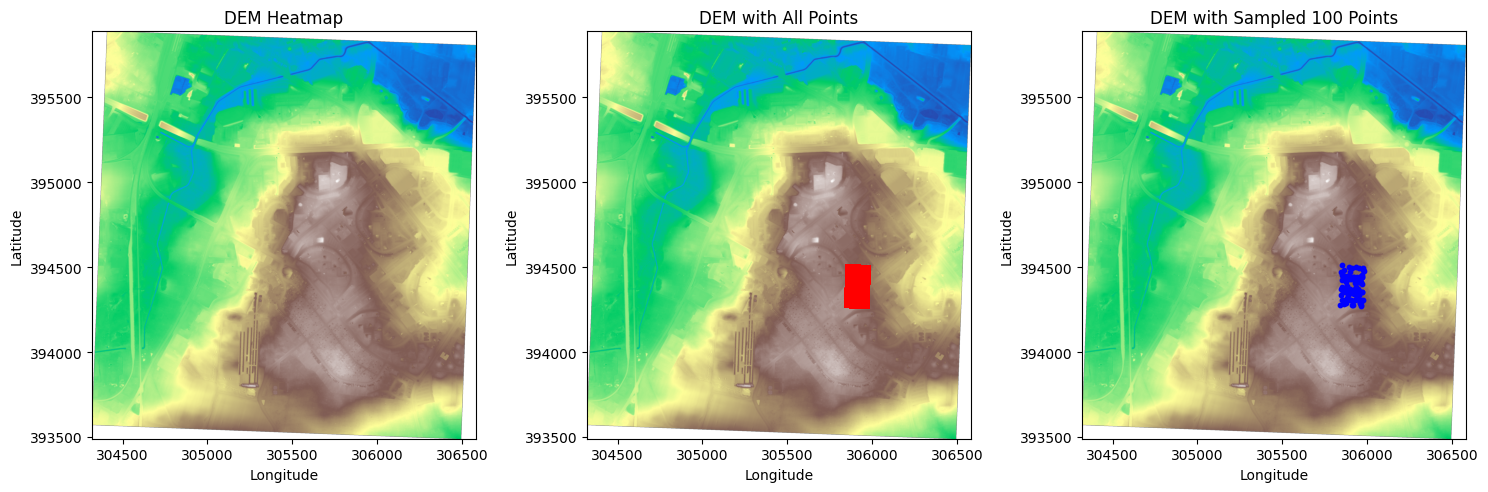

In [4]:
# ---------- Step 3. Visualise DEM, point cloud and samle points ----------

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

if dem_src.nodata is not None:
    dem_masked = np.ma.masked_equal(dem_array, dem_src.nodata)
else:
    dem_masked = dem_array
    
# Plot 1: DEM heatmap
axes[0].imshow(dem_masked, cmap="terrain", extent=dem_extent, origin="upper")
axes[0].set_title("DEM Heatmap")

# Plot 2: DEM with full point cloud
axes[1].imshow(dem_masked, cmap="terrain", extent=dem_extent, origin="upper")
axes[1].scatter(points.geometry.x, points.geometry.y, s=1, c="red", label="All Points")
axes[1].set_title("DEM with All Points")

# Plot 3: DEM with sampled 100 points
axes[2].imshow(dem_masked, cmap="terrain", extent=dem_extent, origin="upper")
axes[2].scatter(points_sample.geometry.x, points_sample.geometry.y, s=10, c="blue", label="Sampled Points")
axes[2].set_title("DEM with Sampled 100 Points")

# Adjust layout
for ax in axes:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

In [5]:
# ---------- Step 3. Sample the DEM at point locations ----------

# Extract point coordinates (assumes the geometry type is Point)
coords = [(geom.x, geom.y) for geom in points_sample.geometry]

# Open DEM again to sample values at the point coordinates
with rasterio.open("C:/Users/user/Studia_RSG/S2/Python_Matlab_for_Geoscience/Exam/Lubin_2024_03_27.asc") as dem_src:
    # The sample() method returns an iterator of arrays (one per band)
    dem_sampled = [val[0] for val in dem_src.sample(coords)]

# Add the sampled DEM heights to the GeoDataFrame
points_sample["DEM_H"] = dem_sampled

In [6]:
# ---------- Step 4. Calculate the height difference deltaH ----------

# The point cloud has a field "Z" for its elevation
points_sample["deltaH"] = points_sample["Z"] - points_sample["DEM_H"]

In [7]:
# ---------- Step 5. Calculate accuracy metrics ----------

deltaH = points_sample["deltaH"].values
mean_error = np.mean(deltaH)
rmse = np.sqrt(np.mean(deltaH**2))
mae = np.mean(np.abs(deltaH))
std_dev = np.std(deltaH)

print("\nAccuracy Metrics:")
print(f"Mean Error (ME): {mean_error:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"Standard Deviation: {std_dev:.3f}")


Accuracy Metrics:
Mean Error (ME): 2.230
RMSE: 6.549
MAE: 2.249
Standard Deviation: 6.158
